# Logistic Regression with a Neural Network mindset

Welcome to your next programming assignment! You will build a logistic regression classifier to recognize  cats. This assignment will step you through how to do this with a Neural Network mindset, and so will also hone your intuitions about deep learning.

**Instructions:**
- Do not use loops (for/while) in your code, unless the instructions explicitly ask you to do so.

**You will learn to:**
- Build the general architecture of a learning algorithm, including:
    - Initializing parameters
    - Calculating the cost function and its gradient
    - Using an optimization algorithm (gradient descent) 
- Gather all three functions above into a main model function, in the right order.

## 1 - Packages ##

First, let's run the cell below to import all the packages that you will need during this assignment. 
- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [h5py](http://www.h5py.org) is a common package to interact with a dataset that is stored on an H5 file.
- [matplotlib](http://matplotlib.org) is a famous library to plot graphs in Python.
- [PIL](http://www.pythonware.com/products/pil/) and [scipy](https://www.scipy.org/) are used here to test your model with your own picture at the end.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline

In [2]:
def load_dataset():
    with h5py.File(r'C:\Users\Ryan\OneDrive\Documents\Algorithms II\M3\datasets-20250130T233939Z-001\datasets\train_catvnoncat.h5', "r") as train_dataset:
        train_set_x_orig = np.array(train_dataset["train_set_x"][:])
        train_set_y_orig = np.array(train_dataset["train_set_y"][:])

    with h5py.File(r'C:\Users\Ryan\OneDrive\Documents\Algorithms II\M3\datasets-20250130T233939Z-001\datasets\test_catvnoncat.h5', "r") as test_dataset:
        test_set_x_orig = np.array(test_dataset["test_set_x"][:])
        test_set_y_orig = np.array(test_dataset["test_set_y"][:])
        classes = np.array(test_dataset["list_classes"][:])

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

## 2 - Overview of the Problem set ##

**Problem Statement**: You are given a dataset ("data.h5") containing:
    - a training set of m_train images labeled as cat (y=1) or non-cat (y=0)
    - a test set of m_test images labeled as cat or non-cat
    - each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB). Thus, each image is square (height = num_px) and (width = num_px).

You will build a simple image-recognition algorithm that can correctly classify pictures as cat or non-cat.

Let's get more familiar with the dataset. Load the data by running the following code.

In [3]:
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

We added "_orig" at the end of image datasets (train and test) because we are going to preprocess them. After preprocessing, we will end up with train_set_x and test_set_x (the labels train_set_y and test_set_y don't need any preprocessing).

Each line of your train_set_x_orig and test_set_x_orig is an array representing an image. You can visualize an example by running the following code. Feel free also to change the `index` value and re-run to see other images. 

y = [1], it's a 'cat' picture.


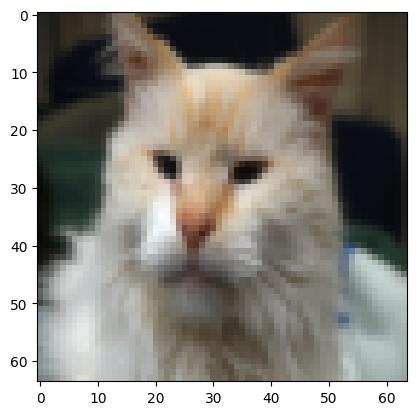

In [4]:
# Example of a picture
index = 27
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:,index]) + ", it's a '" + classes[np.squeeze(train_set_y[:,index])].decode("utf-8") +  "' picture.")

Many software bugs in deep learning come from having matrix/vector dimensions that don't fit. If you can keep your matrix/vector dimensions straight you will go a long way toward eliminating many bugs. 

**Exercise:** Find the values for:
    - m_train (number of training examples)
    - m_test (number of test examples)
    - num_px (= height = width of a training image)
Remember that `train_set_x_orig` is a numpy-array of shape (m_train, num_px, num_px, 3). For instance, you can access `m_train` by writing `train_set_x_orig.shape[0]`.

In [5]:
### START CODE HERE ### (≈ 3 lines of code)
m_train = train_set_x_orig.shape[0] #Retrieves the number of samples/images in m_train. Indexing the 0th column
m_test = test_set_x_orig.shape[0] #Same function as above, but with the test dataset
num_px = train_set_x_orig.shape[1] #Retrieves the pixel number (width and height are the same bc of square image)
#We know to index 0 for the sample number and 1 for the pixel shape becuase we defined train_set_x_orig as an array with (m_train, num_px,num_px, 3)
### END CODE HERE ###

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


**Expected Output for m_train, m_test and num_px**: 
<table style="width:15%">
  <tr>
    <td>**m_train**</td>
    <td> 209 </td> 
  </tr>
  
  <tr>
    <td>**m_test**</td>
    <td> 50 </td> 
  </tr>
  
  <tr>
    <td>**num_px**</td>
    <td> 64 </td> 
  </tr>
  
</table>


For convenience, you should now reshape images of shape (num_px, num_px, 3) in a numpy-array of shape (num_px $*$ num_px $*$ 3, 1). After this, our training (and test) dataset is a numpy-array where each column represents a flattened image. There should be m_train (respectively m_test) columns.

**Exercise:** Reshape the training and test data sets so that images of size (num_px, num_px, 3) are flattened into single vectors of shape (num\_px $*$ num\_px $*$ 3, 1).

A trick when you want to flatten a matrix X of shape (a,b,c,d) to a matrix X_flatten of shape (b$*$c$*$d, a) is to use: 
```python
X_flatten = X.reshape(X.shape[0], -1).T      # X.T is the transpose of X
```

In [6]:
# Reshape the training and test examples

### START CODE HERE ### (≈ 2 lines of code)
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T #Gives us shape of (num_px * num_px, * 3, m_train)
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T
### END CODE HERE ###

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


**Expected Output**: 

<table style="width:35%">
  <tr>
    <td>**train_set_x_flatten shape**</td>
    <td> (12288, 209)</td> 
  </tr>
  <tr>
    <td>**train_set_y shape**</td>
    <td>(1, 209)</td> 
  </tr>
  <tr>
    <td>**test_set_x_flatten shape**</td>
    <td>(12288, 50)</td> 
  </tr>
  <tr>
    <td>**test_set_y shape**</td>
    <td>(1, 50)</td> 
  </tr>
  <tr>
  <td>**sanity check after reshaping**</td>
  <td>[17 31 56 22 33]</td> 
  </tr>
</table>

To represent color images, the red, green and blue channels (RGB) must be specified for each pixel, and so the pixel value is actually a vector of three numbers ranging from 0 to 255.

One common preprocessing step in machine learning is to center and standardize your dataset, meaning that you substract the mean of the whole numpy array from each example, and then divide each example by the standard deviation of the whole numpy array. But for picture datasets, it is simpler and more convenient and works almost as well to just divide every row of the dataset by 255 (the maximum value of a pixel channel).

<!-- During the training of your model, you're going to multiply weights and add biases to some initial inputs in order to observe neuron activations. Then you backpropogate with the gradients to train the model. But, it is extremely important for each feature to have a similar range such that our gradients don't explode. You will see that more in detail later in the lectures. !--> 

Let's standardize our dataset.

In [7]:
train_set_x = train_set_x_flatten / 255.
test_set_x = test_set_x_flatten / 255.

<font color='blue'>
**What you need to remember:**

Common steps for pre-processing a new dataset are:
- Figure out the dimensions and shapes of the problem (m_train, m_test, num_px, ...)
- Reshape the datasets such that each example is now a vector of size (num_px \* num_px \* 3, 1)
- "Standardize" the data

## 3 - General Architecture of the learning algorithm ##

It's time to design a simple algorithm to distinguish cat images from non-cat images.

You will build a Logistic Regression, using a Neural Network mindset. The following Figure explains why **Logistic Regression is actually a very simple Neural Network!**

<img src="images/LogReg_kiank.png" style="width:650px;height:400px;">

**Mathematical expression of the algorithm**:

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

**Key steps**:
In this exercise, you will carry out the following steps: 
    - Initialize the parameters of the model
    - Learn the parameters for the model by minimizing the cost  
    - Use the learned parameters to make predictions (on the test set)
    - Analyse the results and conclude

## 4 - Building the parts of our algorithm ## 

The main steps for building a Neural Network are:
1. Define the model structure (such as number of input features) 
2. Initialize the model's parameters
3. Loop:
    - Calculate current loss (forward propagation)
    - Calculate current gradient (backward propagation)
    - Update parameters (gradient descent)

You often build 1-3 separately and integrate them into one function we call `model()`.

### 4.1 - Helper functions

**Exercise**: Using your code from "Python Basics", implement `sigmoid()`. As you've seen in the figure above, you need to compute $sigmoid( w^T x + b)$ to make predictions.

In [8]:
# GRADED FUNCTION: sigmoid

def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    x -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """

    ### START CODE HERE ### (≈ 1 line of code)
    s = 1 / (1 + np.exp(-z)) #np.exp() is used to compute e^x (Euler's number)
    ### END CODE HERE ###
    
    return s

In [9]:
print ("sigmoid(0) = " + str(sigmoid(0)))
print ("sigmoid(9.2) = " + str(sigmoid(9.2)))

sigmoid(0) = 0.5
sigmoid(9.2) = 0.9998989708060922


**Expected Output**: 

<table style="width:20%">
  <tr>
    <td>**sigmoid(0)**</td>
    <td> 0.5</td> 
  </tr>
  
  <tr>
    <td>**sigmoid(9.2)**</td>
    <td> 0.999898970806 </td> 
  </tr>
</table>

### 4.2 - Initializing parameters

**Exercise:** Implement parameter initialization in the cell below. You have to initialize w as a vector of zeros. If you don't know what numpy function to use, look up np.zeros() in the Numpy library's documentation.

In [10]:
# GRADED FUNCTION: initialize_with_zeros

def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    
    ### START CODE HERE ### (≈ 1 line of code)
    w, b = np.zeros((dim, 1)), 0 #We just needed to specify the dimensions here.
    ### END CODE HERE ###

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

In [11]:
dim = 2
w, b = initialize_with_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]]
b = 0


**Expected Output**: 


<table style="width:15%">
    <tr>
        <td>  ** w **  </td>
        <td> [[ 0.]
 [ 0.]] </td>
    </tr>
    <tr>
        <td>  ** b **  </td>
        <td> 0 </td>
    </tr>
</table>

For image inputs, w will be of shape (num_px $\times$ num_px $\times$ 3, 1).

### 4.3 - Forward and Backward propagation

Now that your parameters are initialized, you can do the "forward" and "backward" propagation steps for learning the parameters.

**Exercise:** Implement a function `propagate()` that computes the cost function and its gradient.

**Hints**:

Forward Propagation:
- You get X
- You compute $A = \sigma(w^T X + b) = (a^{(0)}, a^{(1)}, ..., a^{(m-1)}, a^{(m)})$
- You calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

Here are the two formulas you will be using: 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

In [12]:
# GRADED FUNCTION: propagate

def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    Tips:
    - Write your code step by step for the propagation
    """
    
    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)
    ### START CODE HERE ### (≈ 2 lines of code)
    A = sigmoid(np.dot(w.T, X) + b)
    cost = -(1/m) * np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A))
    ### END CODE HERE ###
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    ### START CODE HERE ### (≈ 2 lines of code)
    dw = (1/m) * np.dot(X, (A - Y).T)
    db = (1/m) * np.sum(A - Y)
    ### END CODE HERE ###

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [13]:
w, b, X, Y = np.array([[1], [2]]), 2, np.array([[1,2], [3,4]]), np.array([[1, 0]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[0.99993216]
 [1.99980262]]
db = 0.49993523062470574
cost = 6.000064773192205


**Expected Output**:

<table style="width:50%">
    <tr>
        <td>  ** dw **  </td>
        <td> [[ 0.99993216]
 [ 1.99980262]]</td>
    </tr>
    <tr>
        <td>  ** db **  </td>
        <td> 0.499935230625 </td>
    </tr>
    <tr>
        <td>  ** cost **  </td>
        <td> 6.000064773192205</td>
    </tr>

</table>

### d) Optimization
- You have initialized your parameters.
- You are also able to compute a cost function and its gradient.
- Now, you want to update the parameters using gradient descent.

**Exercise:** Write down the optimization function. The goal is to learn $w$ and $b$ by minimizing the cost function $J$. For a parameter $\theta$, the update rule is $ \theta = \theta - \alpha \text{ } d\theta$, where $\alpha$ is the learning rate.

In [14]:
# GRADED FUNCTION: optimize

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        
        # Cost and gradient calculation (≈ 1-4 lines of code)
        ### START CODE HERE ### 
        grads, cost = propagate(w, b, X, Y)
        ### END CODE HERE ###
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule (≈ 2 lines of code)
        ### START CODE HERE ###
        w = w - learning_rate * dw
        b = b - learning_rate * db
        ### END CODE HERE ###
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training examples
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" % (i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [15]:
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[0.1124579 ]
 [0.23106775]]
b = 1.5593049248448891
dw = [[0.90158428]
 [1.76250842]]
db = 0.4304620716786828


**Expected Output**: 

<table style="width:40%">
    <tr>
       <td> **w** </td>
       <td>[[ 0.1124579 ]
 [ 0.23106775]] </td>
    </tr>
    
    <tr>
       <td> **b** </td>
       <td> 1.55930492484 </td>
    </tr>
    <tr>
       <td> **dw** </td>
       <td> [[ 0.90158428]
 [ 1.76250842]] </td>
    </tr>
    <tr>
       <td> **db** </td>
       <td> 0.430462071679 </td>
    </tr>

</table>

**Exercise:** The previous function will output the learned w and b. We are able to use w and b to predict the labels for a dataset X. Implement the `predict()` function. There is two steps to computing predictions:

1. Calculate $\hat{Y} = A = \sigma(w^T X + b)$

2. Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5), stores the predictions in a vector `Y_prediction`. If you wish, you can use an `if`/`else` statement in a `for` loop (though there is also a way to vectorize this). 

# GRADED FUNCTION: predict

def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    ### START CODE HERE ### (≈ 1 line of code)
    A = sigmoid(np.dot(w.T, X) + b)
    ### END CODE HERE ###
    
    for i in range(A.shape[1]):
        # Convert probabilities a[0,i] to actual predictions p[0,i]
        ### START CODE HERE ### (≈ 4 lines of code)
        Y_prediction[0, i] = 1 if A[0, i] >=.5 else 0
        ### END CODE HERE ###
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [16]:
def predict(w, b, X):
    """
    Predicts probabilities for logistic regression.

    Arguments:
    w -- weights, numpy array of shape (num_px * num_px * 3, 1)
    b -- bias, scalar
    X -- input data, numpy array of shape (num_px * num_px * 3, m)

    Returns:
    probabilities -- predicted probabilities for each example in X
    """
    # Compute the linear combination
    Z = np.dot(w.T, X) + b  # Linear transformation (Wx + b)
    A = sigmoid(Z)  # Apply sigmoid function to get probabilities between 0 and 1
    return A  # Return raw probabilities (values between 0 and 1)


In [17]:
print("predictions = " + str(predict(w, b, X)))

predictions = [[0.99987661 0.99999386]]


**Expected Output**: 

<table style="width:30%">
    <tr>
         <td>
             **predictions**
         </td>
          <td>
            [[ 1.  1.]]
         </td>  
   </tr>

</table>


<font color='blue'>
**What to remember:**
You've implemented several functions that:
- Initialize (w,b)
- Optimize the loss iteratively to learn parameters (w,b):
    - computing the cost and its gradient 
    - updating the parameters using gradient descent
- Use the learned (w,b) to predict the labels for a given set of examples

## 5 - Merge all functions into a model ##

You will now see how the overall model is structured by putting together all the building blocks (functions implemented in the previous parts) together, in the right order.

**Exercise:** Implement the model function. Use the following notation:
    - Y_prediction for your predictions on the test set
    - Y_prediction_train for your predictions on the train set
    - w, costs, grads for the outputs of optimize()

In [18]:
# GRADED FUNCTION: model

def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    ### START CODE HERE ###
    # initialize parameters with zeros (≈ 1 line of code)
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    ### END CODE HERE ###

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

Run the following cell to train your model.

In [19]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 88.07203207202815 %
test accuracy: 64.84681179962288 %


**Expected Output**: 

<table style="width:40%"> 
    
    <tr>
        <td> **Train Accuracy**  </td> 
        <td> 99.04306220095694 % </td>
    </tr>

    <tr>
        <td>**Test Accuracy** </td> 
        <td> 70.0 % </td>
    </tr>
</table> 




**Comment**: Training accuracy is close to 100%. This is a good sanity check: your model is working and has high enough capacity to fit the training data. Test error is 68%. It is actually not bad for this simple model, given the small dataset we used and that logistic regression is a linear classifier. But no worries, you'll build an even better classifier next week!

Also, you see that the model is clearly overfitting the training data. Later in this specialization you will learn how to reduce overfitting, for example by using regularization. Using the code below (and changing the `index` variable) you can look at predictions on pictures of the test set.

In [20]:
print(type(classes))  # Check the type of the classes variable
print(classes)  # Check the contents of the classes variable

<class 'numpy.ndarray'>
[b'non-cat' b'cat']


y = 0, you predicted that it is a "non-cat" picture.


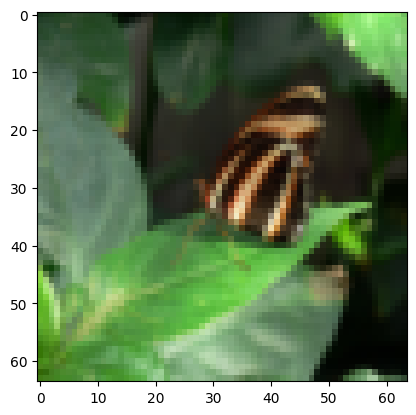

In [21]:
index = 5
plt.imshow(test_set_x[:, index].reshape((num_px, num_px, 3)))  # Display the image

# Check the true label and predicted label
true_label = test_set_y[0, index]  # Get the true label
predicted_label = d["Y_prediction_test"][0, index]  # Get the predicted label

# Cast predicted_label to integer if it's a float .... was getting error 
predicted_label = int(predicted_label)

# Decode classes if they are byte strings
if isinstance(classes, np.ndarray) and isinstance(classes[0], bytes):
    classes = [item.decode("utf-8") for item in classes]  # Decode byte strings to regular strings

# Access the predicted class name
predicted_class = classes[predicted_label]  

print(f"y = {true_label}, you predicted that it is a \"{predicted_class}\" picture.")


In [22]:
print(type(classes))  # Check the type of the classes variable
print(classes)  # Check the contents of the classes variable



<class 'list'>
['non-cat', 'cat']


In [23]:
print(test_set_x.shape)
print(test_set_y.shape)
print(d["Y_prediction_test"].shape)
print(test_set_y[0, index])  # Check if this works
print(d["Y_prediction_test"][0, index])  # Check if this works


(12288, 50)
(1, 50)
(1, 50)
0
0.5284961891400349


Let's also plot the cost function and the gradients.

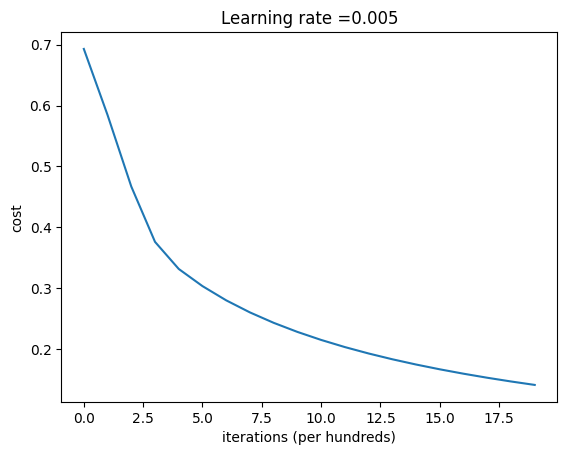

In [24]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

**Interpretation**:
You can see the cost decreasing. It shows that the parameters are being learned. However, you see that you could train the model even more on the training set. Try to increase the number of iterations in the cell above and rerun the cells. You might see that the training set accuracy goes up, but the test set accuracy goes down. This is called overfitting. 

Bibliography:
- http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/
- https://stats.stackexchange.com/questions/211436/why-do-we-normalize-images-by-subtracting-the-datasets-image-mean-and-not-the-c

Homework 4 Start

1. Plot the decrease in the cost function vs iteration count

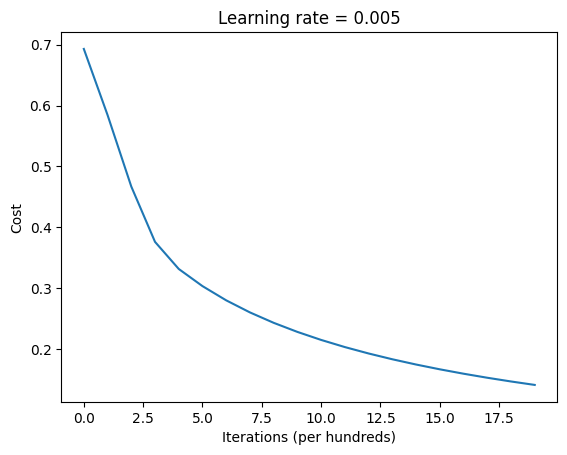

In [25]:
# Decrease in cost function vs iteration count
costs = np.squeeze(d['costs'])  # Remove any extra dimensions if necessary. Makes sure this is a 1D array
plt.plot(costs) #Plots cost against iteration number
plt.ylabel('Cost')
plt.xlabel('Iterations (per hundreds)')
plt.title("Learning rate = " + str(d["learning_rate"])) 
plt.show()


As we can see with the cost graph, the cost drops off fast at the beginning and then starts to lvel off around iteration 1750. This is expected in gradient descent, as larger adjustments will be made at the beginning and the model will converage towards the end of training. The learning rate also impacts the curve as the learning rate limts how much the weights can be changed for the next training iteration. 

2. Play around with different initializations and report whether initializations influence the optimized training cost.

In [26]:
#Recommendations for the initialized weights came from gen AI (chat GPT). 

def initialize_with_random(dim):
    w = np.random.randn(dim, 1)  # Initialize weights randomly from a normal distribution
    b = 0  # Bias is initialized to zero
    return w, b


In [27]:
def initialize_with_small_random(dim):
    w = np.random.randn(dim, 1) * 0.01  # Small random values
    b = 0  # Bias initialized to zero
    return w, b



In [28]:
#Define a function that runs a model for each of our (now 3) initialization circumstances.
def model_with_different_initializations(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    initializations = ['zeros', 'random', 'small_random']
    results = {}

    for init in initializations:
        if init == 'zeros':
            w, b = initialize_with_zeros(X_train.shape[0])
        elif init == 'random':
            w, b = initialize_with_random(X_train.shape[0])
        elif init == 'small_random':
            w, b = initialize_with_small_random(X_train.shape[0])

        # Gradient descent
        parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)

        # Predict test/train set examples
        Y_prediction_test = predict(parameters['w'], parameters['b'], X_test)
        Y_prediction_train = predict(parameters['w'], parameters['b'], X_train)

        # Store results
        results[init] = {
            'costs': costs,
            'train_accuracy': 100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100,
            'test_accuracy': 100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100
        }

    return results


In [29]:
results = model_with_different_initializations(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=2000, learning_rate=0.005, print_cost=True)

# Print and plot results
for init, result in results.items():
    print(f"Initialization: {init.capitalize()}")  # Capitalize the initialization method for neatness
    print(f"  Train accuracy: {result['train_accuracy']:.2f}%")  # Print with two decimal places
    print(f"  Test accuracy: {result['test_accuracy']:.2f}%\n")  # Print with two decimal places and add a newline for spacing
    


Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
Cost after iteration 0: 19.542697
Cost after iteration 100: inf


C:\Users\Ryan\AppData\Local\Temp\ipykernel_66356\883977865.py:27: RuntimeWarning: divide by zero encountered in log
  cost = -(1/m) * np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A))


Cost after iteration 200: inf
Cost after iteration 300: inf
Cost after iteration 400: inf
Cost after iteration 500: inf
Cost after iteration 600: inf
Cost after iteration 700: 4.487819
Cost after iteration 800: 4.220682
Cost after iteration 900: 3.975977
Cost after iteration 1000: 3.750517
Cost after iteration 1100: 3.541859
Cost after iteration 1200: 3.348981
Cost after iteration 1300: 3.169228
Cost after iteration 1400: 2.999241
Cost after iteration 1500: 2.837661
Cost after iteration 1600: 2.683572
Cost after iteration 1700: 2.535304
Cost after iteration 1800: 2.392078
Cost after iteration 1900: 2.254625
Cost after iteration 0: 0.680369
Cost after iteration 100: 0.584482
Cost after iteration 200: 0.466920
Cost after iteration 300: 0.376947
Cost after iteration 400: 0.332957
Cost after iteration 500: 0.304516
Cost after iteration 600: 0.280953
Cost after iteration 700: 0.260993
Cost after iteration 800: 0.243797
Cost after iteration 900: 0.228785
Cost after iteration 1000: 0.215537
C

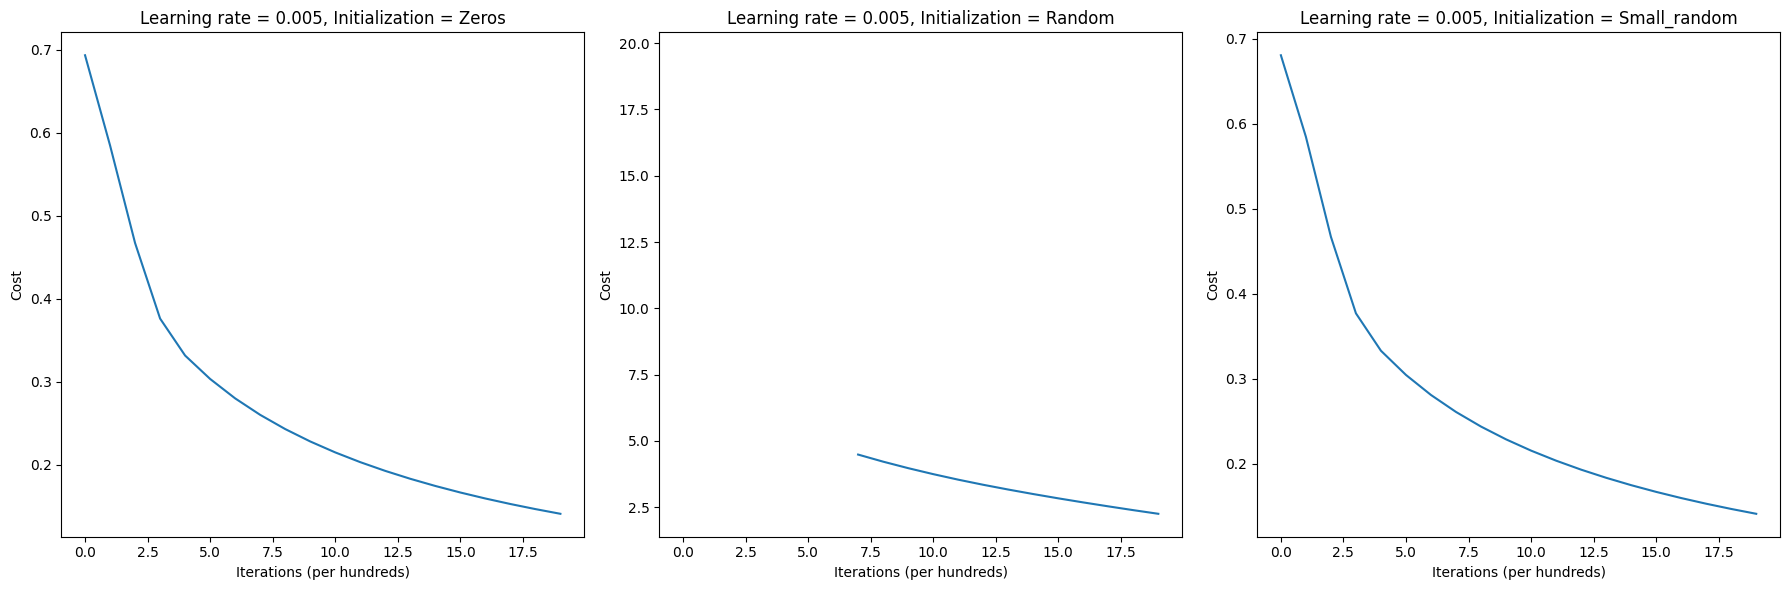

In [30]:
# Create a single figure with 3 subplots for different initializations
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns for each initialization
initializations = ['zeros', 'random', 'small_random']

# Plot the cost function for each initialization method
for i, init in enumerate(initializations):
    ax = axes[i]
    ax.plot(np.squeeze(results[init]['costs']))
    ax.set_title(f"Learning rate = 0.005, Initialization = {init.capitalize()}")
    ax.set_xlabel('Iterations (per hundreds)')
    ax.set_ylabel('Cost')

plt.tight_layout()  # Automatically adjust subplot spacing for a clean layout
plt.show()

I found the results a little suprising. 
1. Initializations: Zeros: This is the same curve we see in question 1 of HW4. The loss curve is pretty normal in shape (as in what is to be expected), with a sharp drop off in loss at the beginning and diminishing returns at the end. The training finished with a loss of about .140 after 1900 iterations. See the above print statements to see the changing gradient of decreasing losses as the training progresses. One reason why zero initialization can cause issues is the symmetry problem (geeksforgeeks.com: https://www.geeksforgeeks.org/what-are-the-cases-where-it-is-fine-to-initialize-all-weights-to-zero/). Essentially, if all weights start at zero, there is a chance the neurons in the model will learn the same features. This is less of a concern in logistic models (like this one) but can still cause convergence to be slower and can cause problems such as being stuck in a local minimum and never reaching the model's full potential. 

2. Random initialization. This graph was slightly suprising to me, as I expected better convergence. However, we are not seeing that. We are seeing a very linear cost loss with consistent rate of change. This differs from the other two methods where we see an exponential decay behavior. As we can see this model is taking much longer to converge. Given enough iterations, it would most likely converge to the .2 range like the other two models. We could potentially increase performance here by increasing the learning rate. Oftentimes in regression true weights are not high magnitude, as in they are generally smaller numbers vs large numbers. Randomly initializing the weights could start us with some large values that are far away from the true weights, and in combination with a small learning rate, could be the reason we are seeing worse convergence and higher loss. The loss after 1900 iterations is 1.56 which is higher than the loss of the other two methods at their starting point! This method will fix the symmetry issue.

3. This third method uses random initialization and then shrinks the number by two orders of magnitude (.01). This makes it so we have random non-zero weights that are small. This gives us the benefit of both methods... we solve the symmetry issue of the weights learning in parallel (more of a concern in NNs) and we also get a better looking cost curve that shows diminishing returns. The loss after 1900 iterations is .140, the same as the zero intialization. There is a chance the numbers are so small they are close enough to zero to mimick the zero initializations scenerio.

Overall, it seems the best stratedgy to use is random initialization with small weights, potentially using a normal distribution and multiplying the random number by .1 instead of .01. 

3. Compute the confusion matrix and then evaluate the precision, recall, and False Positive Rate of your trained algorithm.

In [31]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# Access the predictions from the dictionary returned by the model
Y_prediction_test = d["Y_prediction_test"]
Y_test = test_set_y  # Make sure you use the correct true labels

# Convert predictions to 0 or 1 (because we want a binary classification output)
Y_prediction_test = (Y_prediction_test >= 0.5).astype(int)

# Compute the confusion matrix
cm = confusion_matrix(Y_test.flatten(), Y_prediction_test.flatten())

# Extract TP, TN, FP, FN from the confusion matrix
TN, FP, FN, TP = cm.ravel()

# Compute precision, recall, and false positive rate
precision = precision_score(Y_test.flatten(), Y_prediction_test.flatten())
recall = recall_score(Y_test.flatten(), Y_prediction_test.flatten())
fpr = FP / (FP + TN)

# Print results
print("Confusion Matrix:")
print(cm)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"False Positive Rate: {fpr:.4f}")



Confusion Matrix:
[[12  5]
 [10 23]]
Precision: 0.8214
Recall: 0.6970
False Positive Rate: 0.2941


Our testing set has 50 samples in it, and the confusion matrix adds up to 50 samples.

This means that...
True Negative = 12
False Positive = 5
False Negative = 10
True Positive = 23

Precision: Proportion of positive predictions that are correct. Precision is calculated by TP / (TP + FP) ... 23/(23 + 5) = .8214

Recall: True Positive Rate is the proportion of correctly defined positives. Recall is calculated by: TP / (TP + FN) ... 23 / (23 + 10) = .6970. 

False Positive Rate: Proportion of true negatives that were identified by the model as positives. FPR is calculated by FP/(FP + TN)... 5 / (5 + 12) = .2941. 

4. Split your datasets in different ratios (80:20, 50:50, 20:80) and report the metrics in 1. Comment on whether the split ratio makes a difference to model performance. 

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.591404
Cost after iteration 200: 0.441074
Cost after iteration 300: 0.335342
Cost after iteration 400: 0.295822
Cost after iteration 500: 0.266229
Cost after iteration 600: 0.242164
Cost after iteration 700: 0.222127
Cost after iteration 800: 0.205139
Cost after iteration 900: 0.190528
Cost after iteration 1000: 0.177811
Cost after iteration 1100: 0.166637
Cost after iteration 1200: 0.156735
Cost after iteration 1300: 0.147898
Cost after iteration 1400: 0.139964
Cost after iteration 1500: 0.132801
Cost after iteration 1600: 0.126302
Cost after iteration 1700: 0.120381
Cost after iteration 1800: 0.114964
Cost after iteration 1900: 0.109991
train accuracy: 90.44214526829009 %
test accuracy: 58.34757575128122 %
Training set size: 9830, Test set size: 2457
Confusion Matrix:
[[19 11]
 [ 5  7]]
Precision: 0.3889
Recall: 0.5833
False Positive Rate: 0.3667


Cost after iteration 0: 0.693147
Cost after iteration 100: 0.446146
Cost aft

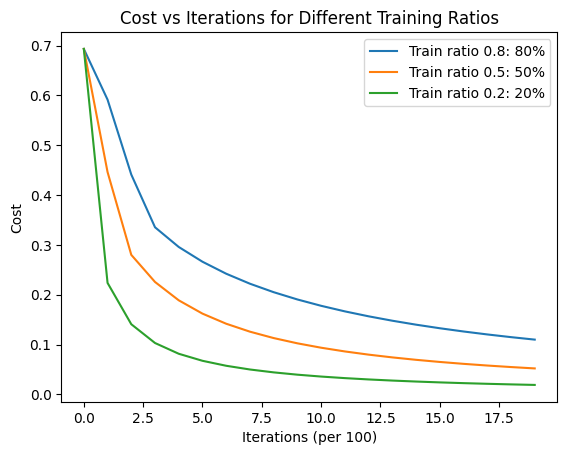

In [32]:
from sklearn.model_selection import train_test_split

# Function to compute and print confusion matrix, precision, recall, and FPR
def evaluate_model(Y_test, Y_prediction_test):
    Y_prediction_test = (Y_prediction_test >= 0.5).astype(int)  # Convert to 0 or 1
    cm = confusion_matrix(Y_test.flatten(), Y_prediction_test.flatten())

    # Extract TP, TN, FP, FN
    TN, FP, FN, TP = cm.ravel()

    # Calculate precision, recall, and false positive rate
    precision = precision_score(Y_test.flatten(), Y_prediction_test.flatten())
    recall = recall_score(Y_test.flatten(), Y_prediction_test.flatten())
    fpr = FP / (FP + TN)

    # Print results
    print("Confusion Matrix:")
    print(cm)
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"False Positive Rate: {fpr:.4f}")
    print("\n")

# Function to split the dataset and evaluate the model for different ratios
def evaluate_splits(X, Y, splits=[(0.8, 0.2), (0.5, 0.5), (0.2, 0.8)]):
    for train_ratio, test_ratio in splits:
        # Split the dataset according to the specified ratio
        X_train, X_test, Y_train, Y_test = train_test_split(X.T, Y.T, train_size=train_ratio, random_state=42)

        # Train the model using the given training and test data
        d = model(X_train.T, Y_train.T, X_test.T, Y_test.T, num_iterations=2000, learning_rate=0.005, print_cost=True)

        # Evaluate the model
        print(f"Training set size: {int(train_ratio * len(X))}, Test set size: {int(test_ratio * len(X))}")
        evaluate_model(Y_test, d["Y_prediction_test"])

        # Plot the cost vs. iterations
        plt.plot(np.squeeze(d["costs"]), label=f"Train ratio {train_ratio}: {int(train_ratio*100)}%")
    
    # Add labels and legend to the plot
    plt.xlabel('Iterations (per 100)')
    plt.ylabel('Cost')
    plt.title("Cost vs Iterations for Different Training Ratios")
    plt.legend()
    plt.show()

# Now call the function to evaluate the model on different splits and plot costs
evaluate_splits(train_set_x, train_set_y, splits=[(0.8, 0.2), (0.5, 0.5), (0.2, 0.8)])




As we can see from the output above, train/test split ratios do make a difference for model performance. The cost was highest with 80% train data ratio, second highest for 50% and lowest for 20%. This does not mean that the 20% train split performed better as evident from the test accuracy for each trial. Note that all the training accuracies ended up being 100% which is concerning for overfitting. The 80% train split gave a test accuracy of 62%, 50% split gave 55% accuracy, and the 20% split gave a 50% test accuracy. So as we see, the less data proportionally in the training set, creates worse accuracy on the test set regardless of final training loss. One reason for the lower loss on the 20% split is there is less data for the model to analyze. It has a better chance of memorizing some of the data with there being less. When testing on more data than it trained on, the model is seeing patterns for the first time and is guessing on the model. Remember that we are doing binary classification: cat or dog, so the 50% test accuracy for the 20/80 split is terrible! It is just the same as the model making a 50/50 guess on each sample... it is the worst possible performing model... completely random guessing. 

From seeing this, I would recommend using the widely accepted and standard 80% training data and 20% testing data. 

5. For the 80:20 split case, evaluate the performance metrics in 3 and also ROC as you vary the probability threshold.

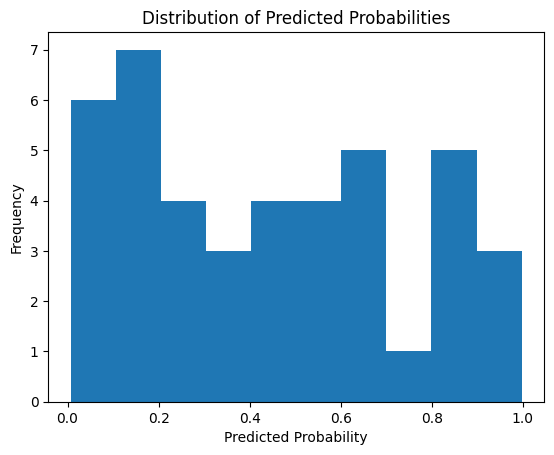

In [38]:
plt.hist(Y_prediction_test.flatten(), bins=10)
plt.title("Distribution of Predicted Probabilities")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.show()


In [37]:
print("Predicted probabilities:", Y_prediction_test[:10])  # Check first 10 predictions


Predicted probabilities: [[0.49607966 0.33229868 0.38818437 0.21519291 0.60068098 0.87973525
  0.83481066 0.18804227 0.45383397 0.58723352 0.86578215 0.12110205
  0.12765925 0.51004309 0.36008182 0.99711316 0.08828277 0.61110225
  0.62928876 0.8899303  0.72102224 0.00693835 0.93954149 0.67793629
  0.62719063 0.08185422 0.29470218 0.01505799 0.03372832 0.48744428
  0.11932946 0.07370725 0.21718624 0.79958922 0.95930202 0.17928347
  0.43300456 0.54437145 0.1114901  0.11283853 0.61218468 0.27435283]]


Cost after iteration 0: 0.693147
Cost after iteration 100: 0.591404
Cost after iteration 200: 0.441074
Cost after iteration 300: 0.335342
Cost after iteration 400: 0.295822
Cost after iteration 500: 0.266229
Cost after iteration 600: 0.242164
Cost after iteration 700: 0.222127
Cost after iteration 800: 0.205139
Cost after iteration 900: 0.190528
Cost after iteration 1000: 0.177811
Cost after iteration 1100: 0.166637
Cost after iteration 1200: 0.156735
Cost after iteration 1300: 0.147898
Cost after iteration 1400: 0.139964
Cost after iteration 1500: 0.132801
Cost after iteration 1600: 0.126302
Cost after iteration 1700: 0.120381
Cost after iteration 1800: 0.114964
Cost after iteration 1900: 0.109991
train accuracy: 90.44214526829009 %
test accuracy: 58.34757575128122 %


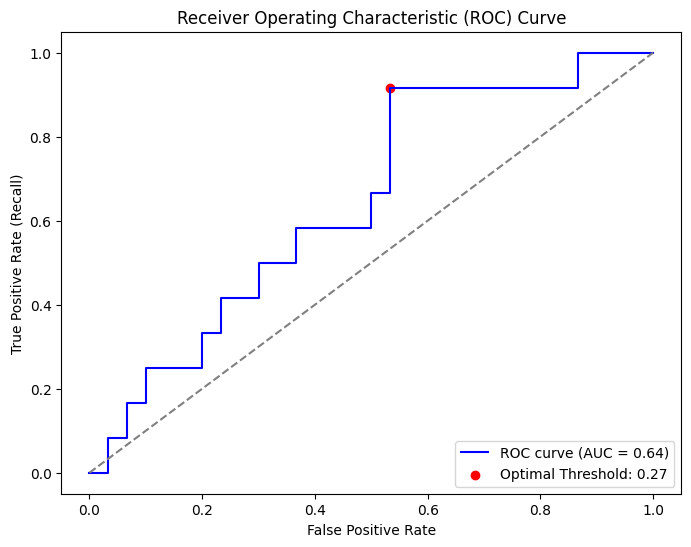

Optimal Threshold (based on distance to (0, 1)): 0.27


In [35]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Function to compute and plot the ROC curve with the optimal threshold
def plot_roc_curve_with_optimal_threshold(Y_test, Y_prediction_test):
    # Compute FPR and TPR for various threshold values (continuous values)
    fpr, tpr, thresholds_roc = roc_curve(Y_test.flatten(), Y_prediction_test.flatten())
    
    # Compute the Area Under the Curve (AUC)
    auc_value = auc(fpr, tpr)

    # Calculate the Euclidean distance from each point (FPR, TPR) to the ideal point (0, 1)
    distances = np.sqrt(fpr**2 + (1 - tpr)**2)
    
    # Find the index of the minimum distance (the optimal threshold)
    optimal_idx = np.argmin(distances)
    optimal_threshold = thresholds_roc[optimal_idx]

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc_value:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
    
    # Mark the optimal threshold on the ROC curve
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', marker='o', label=f'Optimal Threshold: {optimal_threshold:.2f}')
    
    # Add labels and legend
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print the optimal threshold
    print(f"Optimal Threshold (based on distance to (0, 1)): {optimal_threshold:.2f}")

# Train the model using the 80:20 split
X_train, X_test, Y_train, Y_test = train_test_split(train_set_x.T, train_set_y.T, train_size=0.8, random_state=42)

# Train the model
d = model(X_train.T, Y_train.T, X_test.T, Y_test.T, num_iterations=2000, learning_rate=0.005, print_cost=True)

# Get predicted probabilities for the test set
Y_prediction_test = d["Y_prediction_test"]

# Plot the ROC curve with the optimal threshold
plot_roc_curve_with_optimal_threshold(Y_test, Y_prediction_test)


As we can see probability threshold has a big effect on model performance. With a threshold of 0.0, the model is giving us a 100% false positive rate and 100% recall. The model here is classifying everything as a positive becuase it is using a 0% probability threshold (not super helpful). As we increase the threshold we see that false positive rate and recall decrease where the precision increases. This is expected and this is the foundations of an ROC curve. We plot the optimal threshold for our model that comes out to be .27. The ROC is .64 sugguesting a weaker model. It is over the baseline of .5 which is good, meaning it supplies some value, but .64 is not a great score. 

6. Visualize 3 examples of True-Positives, True-Negatives, False-Positives, and False-Negatives.

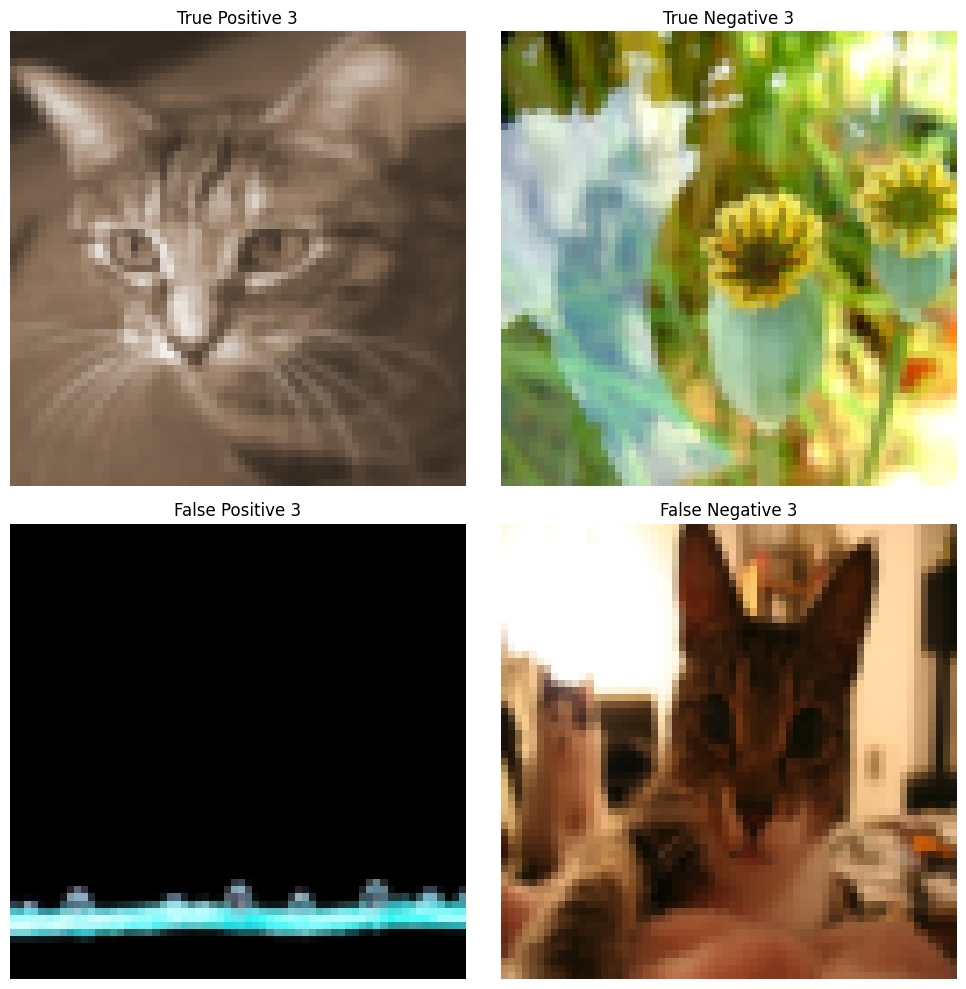

In [36]:

# Function to visualize confusion examples
def visualize_confusion_examples(X_test, Y_test, Y_prediction_test, threshold=0.5, num_examples=3, num_px=64):
    # Convert predicted probabilities to binary predictions based on the threshold
    Y_prediction_test_bin = (Y_prediction_test >= threshold).astype(int)

    # Flatten arrays for easier comparison
    Y_test = Y_test.flatten()
    Y_prediction_test_bin = Y_prediction_test_bin.flatten()

    # Get indices for TP, TN, FP, FN
    TP = np.where((Y_test == 1) & (Y_prediction_test_bin == 1))[0][:num_examples]
    TN = np.where((Y_test == 0) & (Y_prediction_test_bin == 0))[0][:num_examples]
    FP = np.where((Y_test == 0) & (Y_prediction_test_bin == 1))[0][:num_examples]
    FN = np.where((Y_test == 1) & (Y_prediction_test_bin == 0))[0][:num_examples]

    # Plotting
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))

    # True Positives
    for i, idx in enumerate(TP):
        image = X_test[idx].reshape((num_px, num_px, 3))  # Reshape to (64, 64, 3)
        axes[0, 0].imshow(image)
        axes[0, 0].set_title(f"True Positive {i+1}")
        axes[0, 0].axis('off')

    # True Negatives
    for i, idx in enumerate(TN):
        image = X_test[idx].reshape((num_px, num_px, 3))  # Reshape to (64, 64, 3)
        axes[0, 1].imshow(image)
        axes[0, 1].set_title(f"True Negative {i+1}")
        axes[0, 1].axis('off')

    # False Positives
    for i, idx in enumerate(FP):
        image = X_test[idx].reshape((num_px, num_px, 3))  # Reshape to (64, 64, 3)
        axes[1, 0].imshow(image)
        axes[1, 0].set_title(f"False Positive {i+1}")
        axes[1, 0].axis('off')

    # False Negatives
    for i, idx in enumerate(FN):
        image = X_test[idx].reshape((num_px, num_px, 3))  # Reshape to (64, 64, 3)
        axes[1, 1].imshow(image)
        axes[1, 1].set_title(f"False Negative {i+1}")
        axes[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

#Use it!
visualize_confusion_examples(X_test, Y_test, Y_prediction_test)
